## Introduction

Over the last two lessons, we took a look at a few of the more common plotting functions in the matplotlib library. Matplotlib provides quite a few plotting functions right out of the box, but from time-to-time you're bound to run into one that's missing. One useful visualization technique that is currently absent from the matplotlib library is the parallel coordinates technique. Lucky for us, it's relatively easy to create our own parallel coordinates plotting function, and in this lesson, we'll see how to use what we've learned in the past couple of lessons to create a custom visualization function.

### Parallel Coordinates

The [parallel coordinates][1] technique is a useful tool for understanding multi-dimensional numerical data, and it can be used to easily visualize clusters in these high-dimensional data sets. This technique displays each observation in a data set as a separate line in the graph where each point in the line is the value for a specific feature in the data set. The visualization can also have variable `y-axis` scales for each feature, but this isn't necessarily a requirement, and so we'll be leaving that part out of our plotting function, to make things a bit easier on us.

So, now that we have a decent understanding of what we'll be creating, let's go ahead and get our environment setup so we can dive right into the creation of our custom plotting function.

[1]: https://eagereyes.org/techniques/parallel-coordinates

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Getting the Data

In this lesson, as in the last, we'll be using the [Iris data set][1] to test out our plotting function. So, the code below is exactly the same as what we used in the previous lesson to download and load in the data from the [UCI Machine Learning Repository][2].

[1]: https://en.wikipedia.org/wiki/Iris_flower_data_set
[2]: https://archive.ics.uci.edu/ml/datasets/Iris

In [2]:
import csv
import urllib2
from collections import namedtuple

# Create a namedtuple constructor for each record in the Iris data
#    1. sepal length in cm
#    2. sepal width in cm
#    3. petal length in cm
#    4. petal width in cm
#    5. class: 
#       -- Iris-setosa
#       -- Iris-versicolour
#       -- Iris-virginica
fields = ('sepal_length', 
          'sepal_width', 
          'petal_length', 
          'petal_width', 
          'species')
IrisRecord = namedtuple('IrisRecord', fields)

# Download and read in the data from the UCI Machine Learning Repository
response = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
iris_data_csv = response.read().strip()

# Convert each record into a format that's easier to work with (i.e.,
# wrap each record in the namedtuple that we created).
data = []
for row in csv.reader(iris_data_csv.splitlines()):
    data.append(IrisRecord(
        sepal_length          = float(row[0]),
        sepal_width           = float(row[1]),
        petal_length          = float(row[2]),
        petal_width           = float(row[3]),
        species               = row[4]))

## Creating a Parallel Coordinates Function

And, now that we have our data loaded in, we're ready to create our plotting function.

The first two lines in the code below import the `cycle` function from the `itertools` module and the `defaultdict` function from the `collections` module just like we did in our last lesson so we can create a simple color map that we'll use to color code the different classes in our data. The first few lines of our plotting function (lines 8 and 9) use the imported functions to create that color map. The first line calls the `cycle` function on the default list of colors. This will create an iterator that just repeats once the underlying list has been exhausted. On the next line we create the color map, which is just a dictionary that will grab the next color from our color iterator whenever a key is passed in that doesn't already exist in the color map.

Notice that our `parallelcoords` function takes two parameters: the first one is the 2-dimensional matrix of data that we want to visualize, and the second is a boolean that tells us whether or not the matrix contains a column for a target variable. 

> On a side note, a target variable is a variable that contains some type of classification of an observation, and an observation is just another name for a record in a data set. It's called a target variable because it's usually the value that we're trying to predict in a machine learning model. So, for example, in our data, the target variable would be the species of the flower, and so we could create a model (e.g., a decision tree) that would take a bit of data for a flower (like the petal length and width) and then try to determine its species based on that data, i.e., predict its target variable.

Ok, that aside, let's get back to our plotting function's interface. 

On lines 15-21 we see the meat of the plotting function. In this bit of code we loop through each record in our data set and plot each one as a separate line in the graph. But, before doing so, we check if there's a target variable in the data set. If one does exist, we assume it's the last variable in the record, and we plot everything but that last column. Then, we use the last column to pick the color for the current line from our color map. If there is no target variable in the data set, we simply plot all of the data for the current record and let matploltib pick out the color.

Everything after line 21 is just cleaning up the graphic to make it a bit easier to read. We start with properly labeling the `x-axis`. To do this, we'll need to get a list of the feature names from the `_fields` attribute of the `namedtuple`s in our data set. Lines

If the user has passed in a list of `namedtuples`, we will pull a list of feature names from the `_fields` attribute and use those names to label the `x-axis` ticks. Line 29 tries to get that list and if the data doesn't contain nicely labeled `namedtuple`s, we simply go with a range of numbers for the `x-axis` labels, which is what line 31 is doing. Finally, line 32 takes the feature names list that we pulled from the data set and updates the `x-axis` tick labels with that list.

With the long feature names on the `x-axis`, the graph can look a bit cluttered, so we hide the `y-axis` origin label on line 36 to make it look a bit cleaner.

Line 39 draws the grid lines for `x-axis`.

And, finally, lines 43-55 create a legend. Now, this bit is optional based on whether or not a target variable exists in the data. If a target variable does exist, the first thing we do is pull a list of the unique values from the target variable, which we do on line 45. Then, on line 54, we create a proxy artist (see the previous lesson for an explanation of proxy artists) for each of the classes in the list and give each one a color from the color map we created at the beginning of the function. Lastly, we call the `legend` function and pass in the list of proxy artists to create our legend, and we're done.

In [3]:
from itertools import cycle
from collections import defaultdict

def parallelcoords(m, target=True):
    """Plots parallel coordinates from a 2D matrix of numerical data
    """ 
    # Create a color map of species names to colors
    color_cycler = cycle(plt.rcParams['axes.prop_cycle'])
    cmap = defaultdict(lambda: next(color_cycler)['color'])
        
    # Plot the data, one line for each record in the data set.
    # Remember calling plot continuously works because pyplot
    # keeps track of the current figure and adds a new line
    # to the current figure every time you call plot.
    for record in m:
        # If the data contains a target variable, plot only the features
        # and use the target variable to determine the color of the line
        if target:
            plt.plot(record[:-1], c=cmap[record[-1]])
        else:
            plt.plot(record)

    # Label the x-axis with the name of each feature in the data set.
    try:
        # If each record is a namedtuple, get the list of fields;
        # we'll use those for the x- and y-axis labels of the 
        # scatterplot matrix. If target is True, don't get the
        # last field name.
        features = m[0]._fields[:-1] if target else m[0]._fields 
    except:
        features = range(len(m[0]) - 1) if target else range(len(m[0]))
    plt.xticks(range(len(features)), features)

    # Grab the y-axis from the current Axes object so we can hide the 
    # origin label since it looks a little crowded otherwise.
    plt.gca().yaxis.get_major_ticks()[0].set_visible(False)

    # Show the grid lines for the x-axis
    plt.grid(axis='x')

    # If we have a target variable in the data, create a legend
    # with an entry for each class in the target variable.
    if target:
        # Get the list of classes for the target variable
        classes = list(set(r[-1] for r in m))

        # Create a few "proxy artists" for creating the legend. Calling the 
        # legend() function without passing in any parameters will create a
        # legend for any labeled data in the graph, so we could do something
        # funky where we add a label for one line per species, but that 
        # doesn't seem as simple and clean as just creating a few lines that
        # we use just to create the legend. Plus, this is an officially 
        # sanctioned way to create a legend (just see the legend docs).
        legend_handles = [plt.Line2D([], [], color=cmap[cls], label=cls) for cls in classes]
        plt.legend(handles=legend_handles);

Let's go ahead and give our `parallelcoords` function a try with the Iris data we read in from UCI Machine Learning repository. 

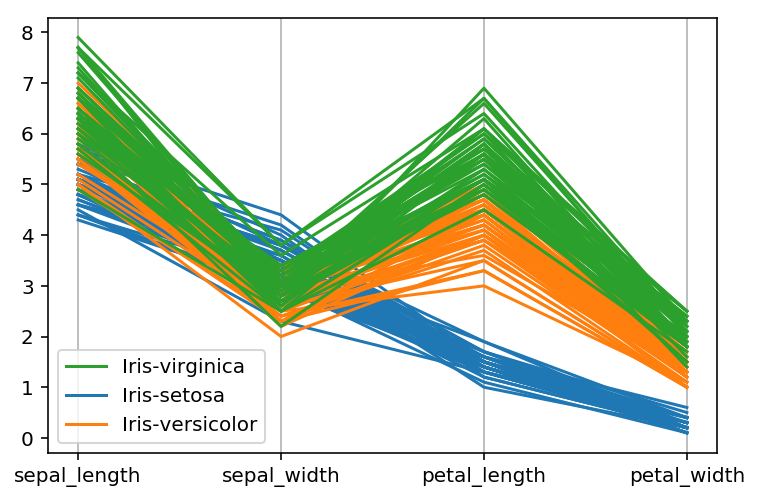

In [4]:
parallelcoords(data)

Using the parallel coordinates technique it's really easy to see that there are at least two definite clusters: one for the setosa species and another for everything else. However, unlike the techniques we saw in previous lessons, e.g., the scatterplot, we can actually see where the divisions between the clusters are greatest on more than just one or two variables. Looking at our graph above, we can see that a good division just does not exist between any of the species when looking at sepal dimensions, but the petal dimensions look like a really good predictor of species. In fact, we can see that there's even a pretty nice separation between the versicolor and virginica species when considering the petal length and width. So, this visualization technique is really useful when trying to determine which features will be most effective when differentiating between different classes in your data. 

## Conclusion

And that will bring us to the end of this lesson, and to the end of our exploration of the plotting functions that matplotlib provides. In this final lesson, we saw how to use the plotting functions that we've learned over the last two lessons to create our own custom visualizations whenever a standard plotting function cannot be found to satisfy our requirements. 